In [14]:
import sys
sys.path.append("/kaggle/input/review-dataset")   

from data_pipe_ids import SkipGramPairIterable


In [18]:
import os
import multiprocessing as mp
import random, torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from functools import partial 
import torch.optim as optim


import matplotlib.pyplot as plt
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

base_dir = "/kaggle/input/review-dataset"
vocab_dir = os.path.join(base_dir, "vocab.pt")
train_corpus_dir = os.path.join(base_dir, "n_train_corpus.bin")
valid_corpus_dir = os.path.join(base_dir, "n_valid_corpus.bin")
train_starts_dir = os.path.join(base_dir, "train_starts.bin")
valid_starts_dir = os.path.join(base_dir, "valid_starts.bin")
vocab = torch.load(vocab_dir, map_location='cpu', weights_only=False)
print("loading vocab...")
word2id = vocab["word2id"]
id2word = vocab["id2word"]
counts = vocab["counts"]
keep_probs = vocab["keep_probs"]
print(keep_probs[word2id["happy"]])
print("loaded vocab...")



loading vocab...
tensor(0.4500)
loaded vocab...


In [22]:
class SGNS(nn.Module):
    def __init__(self, vocab_size=None,*, neg_k=10, dim: int=None, counts: torch.Tensor=None, padding_idx=None):
        super().__init__()
        self.vocab_size = vocab_size
        self.dim = dim
        self.neg_k = neg_k
        self.embed_in = nn.Embedding(vocab_size, dim, padding_idx=padding_idx)
        self.embed_out = nn.Embedding(vocab_size, dim, padding_idx=padding_idx)
        nn.init.uniform_(self.embed_in.weight, -0.5/vocab_size, 0.5/vocab_size)
        nn.init.zeros_(self.embed_out.weight)
        p = counts.float().pow(0.75)
        p = p / p.sum()
        self.register_buffer("unigram75", p)

    @torch.no_grad()
    def neg_sample(self, B, generator=None):
        idx = torch.multinomial(self.unigram75, B*self.neg_k, replacement=True,generator=generator)
        return idx.view(B, self.neg_k).to(dtype=torch.long, device=device)
    
    def forward(self, centers, pos, generator=None):
        neg = self.neg_sample(centers.shape[0], generator)
        v_c = self.embed_in(centers)
        u_o = self.embed_out(pos)
        u_k = self.embed_out(neg)


        pos_score = (v_c * u_o).sum(dim=1)
        
        neg_score = torch.bmm(u_k, v_c.unsqueeze(2)).squeeze(2)

        return -(F.logsigmoid(pos_score) + F.logsigmoid(-neg_score).sum(dim=1)).mean()
    @torch.no_grad()
    def get_input_vectors(self):
        return self.embed_in.weight.detach().clone()
    @torch.no_grad()
    def get_output_vector(self):
        return self.embed_out.weight.detach().clone()
    
    @torch.no_grad()
    def most_similar(self, wid_ids, topn=5, use='input'):
        if use == 'input':
            w = self.embed_in.weight
        elif use == 'output':
            w = self.embed_out.weight
        else:
            w = (self.embed_in.weight + self.embed_out.weight) / 2

        x = w[wid_ids]
        if x.dim() == 1:
            x = x.unsqueeze(0)
    
     
        mu = w.mean(dim=0, keepdim=True)
        C  = w - mu
        q  = min(w.shape[1], 5)
        U, S, V = torch.pca_lowrank(C, q=q, center=False)
        Vk = V[:, :1]                          
        w = C - (C @ Vk) @ Vk.transpose(0, 1)
        x = (x - mu)
        x = x - (x @ Vk) @ Vk.transpose(0, 1)
    
        w_norm = w / (w.norm(dim=1, keepdim=True) + 1e-9)
        x_norm = x / (x.norm(dim=1, keepdim=True) + 1e-9)
        cos = x_norm @ w_norm.T

        if isinstance(wid_ids, torch.Tensor):
            ids = wid_ids.tolist()
        else:
            ids = list(wid_ids)
        for wid in ids:
            cos[:, wid] = -1.0
    
        vals, idx = torch.topk(cos, k=topn, dim=1)
        return vals, idx


def evaluate(model: SGNS, word2id, id2word, wid=["happy", "good", "bad", "shit", "excellent", "outstanding", "masterpiece", "delightful", "awful", "terrible", "boring", "cringe", "waste"]):
    ids = [word2id[i] for i in wid]
    cos, idx = model.most_similar(ids, 4)
    for w, row_idx, row_val in zip(wid, idx, cos):
        print(f"Most similar to {w}:")
        for i, v in zip(row_idx, row_val):
            word = id2word[i.item()]
            print(f"  {word:10s}  Cos: {v.item():.3f}")
        print()
    
class LossPlotter:
    def __init__(self):
        self.train_loss = []
        self.valid_loss = []
    
    def update(self, epoch, new_tloss, new_vloss):
        self.train_loss.append(new_tloss)
        self.valid_loss.append(new_vloss)

        plt.clf()
        plt.plot(range(1, len(self.train_loss)+1), self.train_loss, marker='o', label="Train")
        plt.plot(range(1, len(self.valid_loss)+1), self.valid_loss, marker='s', label="valid")
        plt.xlabel(f"{epoch}")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid = True
        plt.pause(0.01)





In [23]:
keep_probs[word2id["abd"]] = 0.001
keep_probs[word2id["yuk"]] = 0.001


model = SGNS(len(id2word), neg_k=15, counts=counts, dim=300).to(device)
opt = torch.optim.AdamW(
    model.parameters(),
    lr=7.5e-4,           # or whatever base LR you want
    betas=(0.9, 0.99), # smoother 2nd moment
    eps=1e-7,          # stability term
    weight_decay=1e-5  # helps control embedding norm growth)
)


lossplot = LossPlotter()


BATCH_SIZE = 32768
train_pair_iterable = SkipGramPairIterable(path=train_corpus_dir, save_starts_path=train_starts_dir,
                                       train=True, keep_probs=keep_probs,
                                       window=6, batch_size=BATCH_SIZE, seed=121,
                                       device=device)
valid_pair_iterable = SkipGramPairIterable(path=valid_corpus_dir, save_starts_path=valid_starts_dir,
                                       train=False, keep_probs=keep_probs, 
                                       window=5, batch_size=BATCH_SIZE, seed=124,    
                                       device=device)

   
train_loader = DataLoader(train_pair_iterable, batch_size=None, 
                          num_workers=2,      
                          prefetch_factor=8, persistent_workers=True, 
                          pin_memory=True)

valid_loader = DataLoader(valid_pair_iterable, batch_size=None,
                          num_workers=2,      
                          prefetch_factor=8, persistent_workers=True, 
                          pin_memory=True)



step  -200->0: 0.2545623779296875
step  0->200: 13.782234907150269
step  200->400: 13.659896612167358
step  400->600: 13.422771453857422
step  600->800: 13.235936641693115
step  800->1000: 12.88439154624939
step  1000->1200: 12.377171516418457
step  1200->1400: 11.517709732055664
step  1400->1600: 12.500211954116821
total sample: 54680144
Most similar to happy:
  vary        Cos: 0.999
  funny       Cos: 0.999
  bingeable   Cos: 0.999
  enjoyable   Cos: 0.999

Most similar to good:
  si-fi       Cos: 1.000
  goood       Cos: 1.000
  disrupting  Cos: 1.000
  notables    Cos: 1.000

Most similar to bad:
  interest    Cos: 1.000
  wtf         Cos: 1.000
  beginning   Cos: 1.000
  confusing   Cos: 1.000

Most similar to shit:
  flushed     Cos: 1.000
  corrected   Cos: 1.000
  hear        Cos: 1.000
  bec         Cos: 1.000

Most similar to excellent:
  conditon    Cos: 0.999
  not_brilliantly  Cos: 0.999
  cinematographic  Cos: 0.999
  astonishingly  Cos: 0.999

Most similar to outstandin

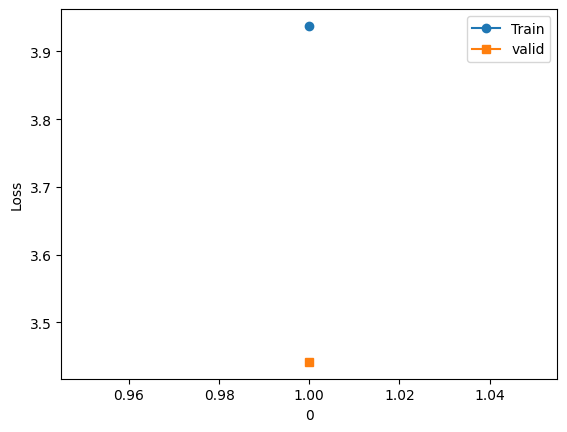

step  -200->0: 7.759976625442505
step  0->200: 13.74898362159729
step  200->400: 13.229323625564575
step  400->600: 14.206821918487549
step  600->800: 12.942719459533691
step  800->1000: 13.00132441520691
step  1000->1200: 12.498967409133911
step  1200->1400: 11.81298565864563
step  1400->1600: 12.499517440795898
total sample: 54680144
Most similar to happy:
  packing     Cos: 0.981
  sealed      Cos: 0.979
  promptly    Cos: 0.977
  brand       Cos: 0.975

Most similar to good:
  natured     Cos: 0.974
  rollicking  Cos: 0.969
  darned      Cos: 0.961
  diff        Cos: 0.958

Most similar to bad:
  horrible    Cos: 0.986
  ending      Cos: 0.970
  wimp        Cos: 0.966
  lame        Cos: 0.966

Most similar to shit:
  dies        Cos: 0.969
  culminate   Cos: 0.966
  bumped      Cos: 0.965
  crack       Cos: 0.963

Most similar to excellent:
  nettles     Cos: 0.985
  iam         Cos: 0.981
  multicultural  Cos: 0.980
  enos        Cos: 0.978

Most similar to outstanding:
  blythe  

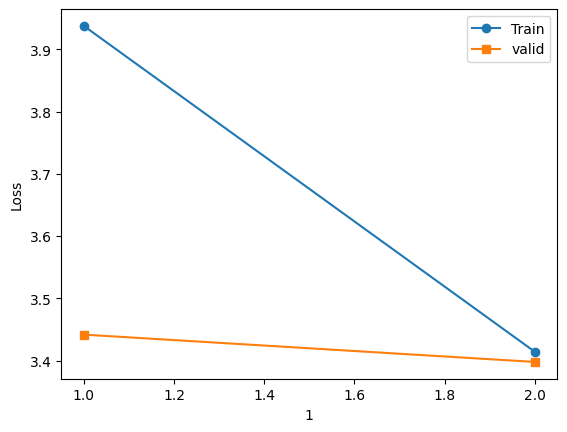

step  -200->0: 7.734518766403198
step  0->200: 13.700517177581787
step  200->400: 13.735546112060547
step  400->600: 13.619747161865234
step  600->800: 12.878040552139282
step  800->1000: 12.7658052444458
step  1000->1200: 12.027540445327759
step  1200->1400: 11.55040192604065
step  1400->1600: 12.246742010116577
total sample: 54680144
Most similar to happy:
  daughter-in-law  Cos: 0.909
  three-year-old  Cos: 0.900
  pleased     Cos: 0.894
  camper      Cos: 0.893

Most similar to good:
  not_outstanding  Cos: 0.918
  ood         Cos: 0.906
  documentry  Cos: 0.901
  not_surprising  Cos: 0.899

Most similar to bad:
  horrible    Cos: 0.922
  not_disappointed  Cos: 0.920
  guys        Cos: 0.900
  guy         Cos: 0.896

Most similar to shit:
  turd        Cos: 0.954
  chasing     Cos: 0.944
  threw       Cos: 0.941
  bust        Cos: 0.935

Most similar to excellent:
  builder     Cos: 0.915
  augustine   Cos: 0.880
  charters    Cos: 0.878
  pullo       Cos: 0.873

Most similar to ou

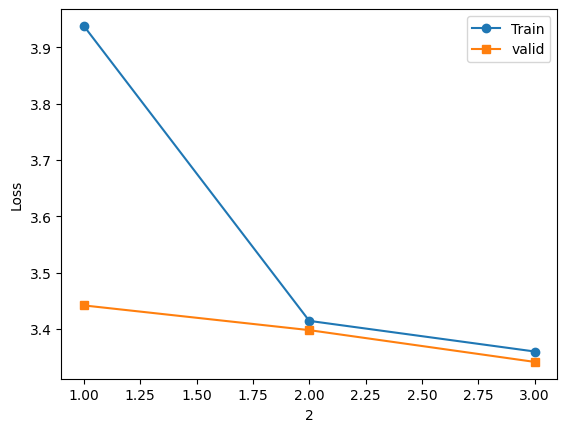

step  -200->0: 7.821167469024658
step  0->200: 13.144819021224976
step  200->400: 13.618011474609375
step  400->600: 13.618133544921875
step  600->800: 13.405796766281128
step  800->1000: 13.407931804656982
step  1000->1200: 13.5361487865448
step  1200->1400: 12.067074060440063
step  1400->1600: 13.080920696258545
total sample: 54680144
Most similar to happy:
  camper      Cos: 0.862
  pleased     Cos: 0.857
  recipient   Cos: 0.849
  satisfied   Cos: 0.845

Most similar to good:
  documentry  Cos: 0.894
  ol' days    Cos: 0.874
  not_connect  Cos: 0.873
  ok          Cos: 0.872

Most similar to bad:
  guys        Cos: 0.856
  horrible    Cos: 0.852
  guy         Cos: 0.815
  damn        Cos: 0.788

Most similar to shit:
  pacifier    Cos: 0.933
  hey         Cos: 0.901
  dude        Cos: 0.901
  um          Cos: 0.895

Most similar to excellent:
  kudo        Cos: 0.852
  pullo       Cos: 0.845
  excellant   Cos: 0.844
  suberb      Cos: 0.843

Most similar to outstanding:
  fantastic

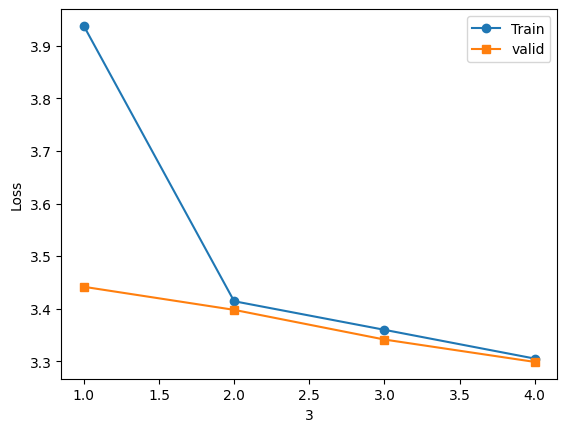

step  -200->0: 8.801459312438965
step  0->200: 15.462666988372803
step  200->400: 14.679197788238525
step  400->600: 14.837463140487671
step  600->800: 13.888330936431885
step  800->1000: 13.621294260025024
step  1000->1200: 13.141652822494507
step  1200->1400: 11.648332357406616
step  1400->1600: 12.746854305267334
total sample: 54680144
Most similar to happy:
  camper      Cos: 0.826
  satisfied   Cos: 0.821
  pleased     Cos: 0.818
  recipient   Cos: 0.795

Most similar to good:
  ol' days    Cos: 0.899
  documentry  Cos: 0.878
  not_surprising  Cos: 0.864
  not_connect  Cos: 0.856

Most similar to bad:
  guys        Cos: 0.751
  horrible    Cos: 0.747
  guy         Cos: 0.726
  ruined      Cos: 0.705

Most similar to shit:
  asses       Cos: 0.895
  dude        Cos: 0.879
  kicker      Cos: 0.871
  pansy       Cos: 0.855

Most similar to excellent:
  giovanni    Cos: 0.859
  excellant   Cos: 0.836
  suberb      Cos: 0.827
  stephan     Cos: 0.816

Most similar to outstanding:
  phe

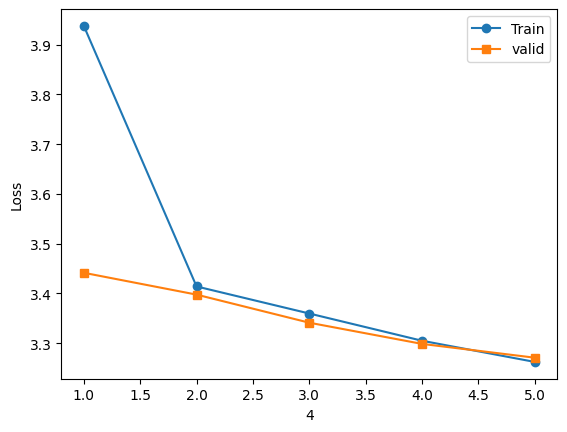

step  -200->0: 8.792898178100586
step  0->200: 14.796882152557373
step  200->400: 13.72811222076416
step  400->600: 14.252992868423462
step  600->800: 13.250344514846802
step  800->1000: 12.766132593154907
step  1000->1200: 12.036836385726929
step  1200->1400: 11.918004035949707
step  1400->1600: 12.554964303970337
total sample: 54680144
Most similar to happy:
  camper      Cos: 0.808
  pleased     Cos: 0.784
  satisfied   Cos: 0.765
  bough       Cos: 0.745

Most similar to good:
  ol' days    Cos: 0.887
  documentry  Cos: 0.865
  goood       Cos: 0.853
  hokie       Cos: 0.850

Most similar to bad:
  guys        Cos: 0.678
  saul        Cos: 0.652
  stinks      Cos: 0.634
  horrible    Cos: 0.634

Most similar to shit:
  asses       Cos: 0.861
  dude        Cos: 0.852
  azz         Cos: 0.836
  abides      Cos: 0.828

Most similar to excellent:
  excellant   Cos: 0.830
  exellent    Cos: 0.806
  suberb      Cos: 0.803
  giovanni    Cos: 0.801

Most similar to outstanding:
  exception

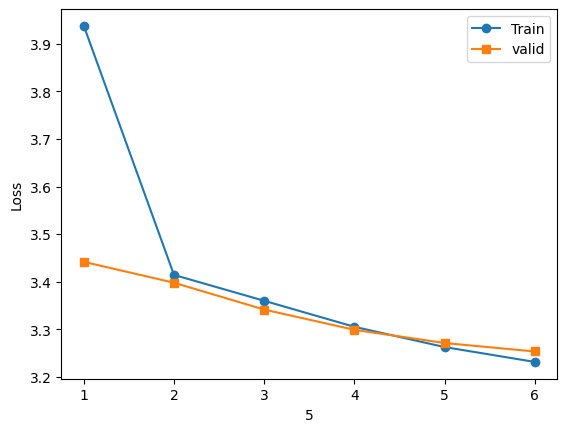

step  -200->0: 8.013115167617798
step  0->200: 14.386171579360962
step  200->400: 13.447782039642334
step  400->600: 14.459420204162598
step  600->800: 13.337175130844116
step  800->1000: 13.121810674667358
step  1000->1200: 11.901570796966553
step  1200->1400: 12.295334100723267
step  1400->1600: 13.132618188858032
total sample: 54680144
Most similar to happy:
  camper      Cos: 0.782
  pleased     Cos: 0.753
  bough       Cos: 0.734
  satisfied   Cos: 0.732

Most similar to good:
  ol' days    Cos: 0.856
  goood       Cos: 0.838
  goog        Cos: 0.824
  moive       Cos: 0.821

Most similar to bad:
  guys        Cos: 0.632
  stinks      Cos: 0.588
  saul        Cos: 0.586
  crappy      Cos: 0.574

Most similar to shit:
  dude        Cos: 0.829
  asses       Cos: 0.824
  azz         Cos: 0.819
  abides      Cos: 0.796

Most similar to excellent:
  excellant   Cos: 0.819
  exellent    Cos: 0.796
  suberb      Cos: 0.768
  not_innovative  Cos: 0.764

Most similar to outstanding:
  fant

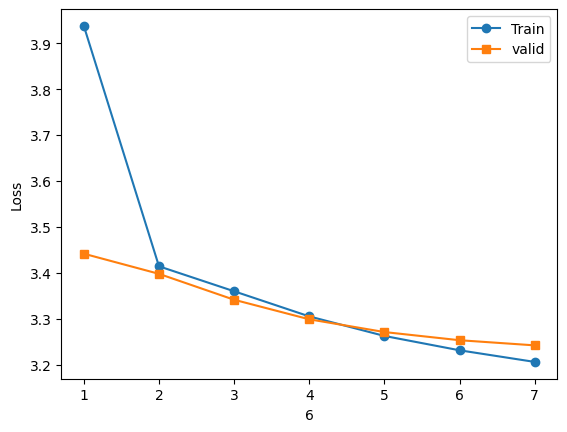

step  -200->0: 8.255419969558716
step  0->200: 14.778573036193848
step  200->400: 14.396930932998657
step  400->600: 14.786332607269287
step  600->800: 13.741723537445068
step  800->1000: 13.571486711502075
step  1000->1200: 12.639919757843018
step  1200->1400: 12.161731004714966
step  1400->1600: 13.165603637695312
total sample: 54680144
Most similar to happy:
  camper      Cos: 0.741
  verygood    Cos: 0.729
  pleased     Cos: 0.726
  satisfied   Cos: 0.710

Most similar to good:
  goood       Cos: 0.827
  ol' days    Cos: 0.822
  goog        Cos: 0.814
  moive       Cos: 0.809

Most similar to bad:
  guys        Cos: 0.594
  laughably   Cos: 0.544
  saul        Cos: 0.535
  stinks      Cos: 0.532

Most similar to shit:
  dude        Cos: 0.796
  azz         Cos: 0.796
  asses       Cos: 0.788
  abides      Cos: 0.740

Most similar to excellent:
  excellant   Cos: 0.815
  exellent    Cos: 0.782
  excelent    Cos: 0.749
  not_innovative  Cos: 0.747

Most similar to outstanding:
  fant

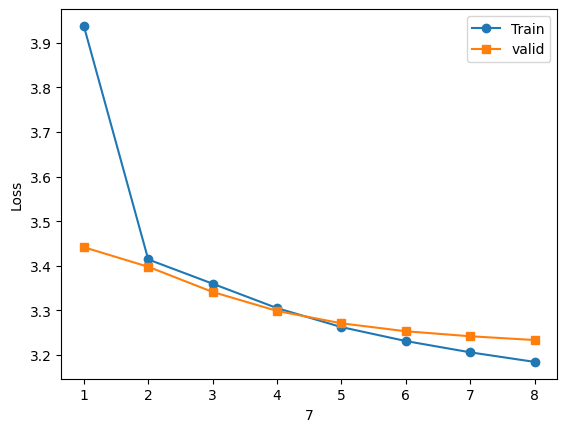

step  -200->0: 8.664872407913208
step  0->200: 14.82568907737732
step  200->400: 14.909195184707642
step  400->600: 14.453571081161499
step  600->800: 13.656111717224121
step  800->1000: 13.82831621170044
step  1000->1200: 12.755138635635376
step  1200->1400: 12.196734428405762
step  1400->1600: 12.754276514053345
total sample: 54680144
Most similar to happy:
  verygood    Cos: 0.737
  pleased     Cos: 0.712
  bough       Cos: 0.699
  camper      Cos: 0.698

Most similar to good:
  goood       Cos: 0.818
  goog        Cos: 0.805
  moive       Cos: 0.795
  ol' days    Cos: 0.787

Most similar to bad:
  guys        Cos: 0.570
  laughably   Cos: 0.532
  horrible    Cos: 0.504
  stinks      Cos: 0.500

Most similar to shit:
  azz         Cos: 0.764
  dude        Cos: 0.751
  asses       Cos: 0.747
  abides      Cos: 0.707

Most similar to excellent:
  excellant   Cos: 0.807
  exellent    Cos: 0.777
  excelent    Cos: 0.745
  vg          Cos: 0.734

Most similar to outstanding:
  fantastic 

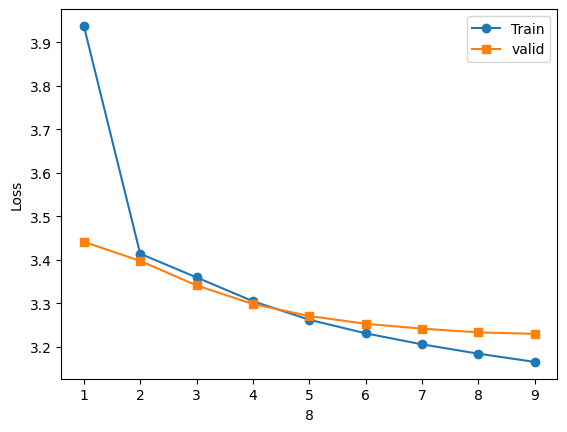

step  -200->0: 8.214635133743286
step  0->200: 14.171500205993652
step  200->400: 14.206904172897339
step  400->600: 14.580723285675049
step  600->800: 13.84188985824585


KeyboardInterrupt: 

In [24]:
start = time.time()
base_seed = 111


for epoch in range(10):
    model.train()
    generator = torch.Generator(device=device).manual_seed(epoch+base_seed)
    train_loss = 0.0
    total_sample = 0
    for step, (center,context) in enumerate(train_loader):
        center = center.to(device, non_blocking=True)
        context = context.to(device, non_blocking=True)
        B = center.shape[0]
        opt.zero_grad(set_to_none=True)
        
        loss = model(center, context, generator=generator)
        loss.backward()
        opt.step()
        train_loss += loss.item() * B
        total_sample += B

        if step % 200 == 0:
            stop = time.time()
            elapsed = stop - start
            prev_step = step-200
            print(f"step  {prev_step}->{step}: {elapsed}")
            start = stop

    print(f"total sample: {total_sample}")
    train_loss = train_loss / total_sample

    model.eval()
    valid_loss = 0.0
    total_sample = 0
    for step, (center, context) in enumerate(valid_loader):
        center = center.to(device, non_blocking=True)
        context = context.to(device, non_blocking=True)
        B = center.shape[0]
        loss = model(center, context, generator)
        opt.step()
        valid_loss += loss.item() * B
        total_sample += B


    valid_loss = valid_loss / total_sample
    evaluate(model, word2id, id2word)
    lossplot.update(epoch, train_loss, valid_loss)

    if epoch == 4 or epoch == 5:
        torch.save(model.embed_in.weight, f"/kaggle/working/epoch{epoch}_in.pt")
        torch.save(model.embed_out.weight, f"/kaggle/working/epoch{epoch}_out.pt")